# Model fitting: Breast Cancer Wisconsin (Prognostic) Dataset

In this notebook I will choose the best model to predict if a person who had invasive breast cancer - with no evidence of distant metastasis - will develop it again during a period of 2 years after the removal of the primary tumor (2-year recurrence). The features for the prediction are taken from imaging results of a biopsy, tumor size and number of positive axillary lymph nodes observed at the time of surgery, "Cancer Wisconsin Prognostic Breast Cancer (WPBC)" dataset. Each observation represents a follow-up of one case of breast cancer.


**Feature information**

1) Outcome (1 = recur, 0 = nonrecur)
2-31) Ten real-valued features are computed for each cell nucleus (biopsy):

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)


	The mean, standard error, and largest (mean of the three
	largest values) of these features were computed for each image,
	resulting in 30 features.  For instance, field 4 is Mean Radius, field
	14 is Radius SE, field 24 is Worst Radius.

32) Tumor size - diameter of the excised tumor in centimeters
33) Lymph node status - number of positive axillary lymph nodes
observed at time of surgery

The performance measure I'll consider to select the model is `F1 score`, since for this scenario it is more important capture the recurrence outcome (decrease the false negative outcomes) and be careful with the false positives. In this way, when the confidence of positive outcomes is high, the poeple that will have a recurrent breast cancer would have more frequent visits to the doctor. 

## 1. Setup

In [1]:

from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from collections import Counter
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
from keras.initializers import GlorotNormal
from scikeras.wrappers import KerasClassifier
from keras import backend as K

np.random.seed(1)
tf.random.set_seed(1)


2023-04-13 09:09:23.187606: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Load data

In [2]:
X_train = pd.read_csv('./data/breastcan_train_X.csv') 
y_train = pd.read_csv('./data/breastcan_train_y.csv') 
X_test = pd.read_csv('./data/breastcan_test_X.csv') 
y_test = pd.read_csv('./data/breastcan_test_y.csv') 

In [3]:
X_train

,texture_mean,area_largest,concavity_largest,fractal_dimension_largest,tumor_size,lymph_node_status
0,-0.095704,1.329176,0.285926,0.268130,0.136861,-0.514371
1,-1.017269,0.897071,-0.535958,0.018027,-0.147526,-0.514371
2,-2.315413,-0.478842,1.014136,0.537859,-0.545667,-0.327327
3,-0.184586,-0.056484,-0.211311,-0.720708,-0.716299,-0.514371
4,0.339350,-0.400868,-1.790277,-0.291457,-0.431912,-0.514371
...,...,...,...,...,...,...
91,-0.044246,2.022818,0.262187,0.321975,-1.000685,-0.327327
92,0.400164,0.032861,-0.507728,-0.713159,-0.545667,-0.327327
93,1.024676,-0.236798,2.902993,0.144337,-0.204403,-0.140283
94,2.498245,1.754783,-0.163191,-0.736308,0.023106,-0.514371


See if the training data is imbalanced by calculating the percentage of positive and negative outcomes:

In [4]:
positives = y_train["outcome"].sum()
positives_per = positives/len(y_train)
negatives_per = 1 - positives_per
print(f"The percentage of positive outcomes is: {positives_per*100:.2f}%.")
print(f"The percentage of negatives outcomes is: {negatives_per*100:.2f}%.")

The percentage of positive outcomes is: 17.71%.
The percentage of negatives outcomes is: 82.29%.


As I mentioned in the dataprep notebook, I was having bad results when oversampling, so I decided just to work with all the observations but few features (the results where bad too when working with all the features).

## 3. Models

Set up the performance dataframe to store the scores of each model.

In [5]:
performance = pd.DataFrame({"model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []})

In [6]:
def performance_metrics(y_test, model_preds, performance, model_name):
    c_matrix = confusion_matrix(y_test, model_preds)
    TP = c_matrix[1][1]
    TN = c_matrix[0][0]
    FP = c_matrix[0][1]
    FN = c_matrix[1][0]
    performance = pd.concat([performance, pd.DataFrame({'model': str(model_name), 
                                                        'Accuracy': [(TP+TN)/(TP+TN+FP+FN+K.epsilon())], 
                                                        'Precision': [TP/(TP+FP+K.epsilon())], 
                                                        'Recall': [TP/(TP+FN+K.epsilon())], 
                                                        'F1': [2*TP/(2*TP+FP+FN+K.epsilon())]
                                                        }, index=[0])])
    return performance

### 3.1 Logistic regression

In [7]:
score_measure = "f1"
kfolds = 5

param_grid = {
    'max_iter': np.arange(4000,4500),
    'C': np.arange(1,20),
    'penalty': ['l2']
}

logiR = LogisticRegression()
rand_search_logiR = RandomizedSearchCV(estimator = logiR, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = rand_search_logiR.fit(X_train, y_train.values.ravel())

print(f"The best {score_measure} score is {rand_search_logiR.best_score_}")
print(f"... with parameters: {rand_search_logiR.best_params_}")

bestf1 = rand_search_logiR.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
The best f1 score is 0.18
... with parameters: {'penalty': 'l2', 'max_iter': 4484, 'C': 6}


In [8]:
#chosen parameters after random search
param_grid = { 
    'max_iter': np.arange(4480,4490),
    'C': np.arange(4,7),
    'penalty': ['l2']
}

grid_search_logiR = GridSearchCV(estimator = logiR, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search_logiR.fit(X_train, y_train.values.ravel())

print(f"The best {score_measure} score is {grid_search_logiR.best_score_}")
print(f"... with parameters: {grid_search_logiR.best_params_}")

bestf1_logiR = grid_search_logiR.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
The best f1 score is 0.18
... with parameters: {'C': 5, 'max_iter': 4480, 'penalty': 'l2'}


In [9]:
performance = performance_metrics(y_test, bestf1_logiR.predict(X_test), performance, "logistic l2")
performance

,model,Accuracy,Precision,Recall,F1
0,logistic l2,0.761905,1.0,0.090909,0.166667


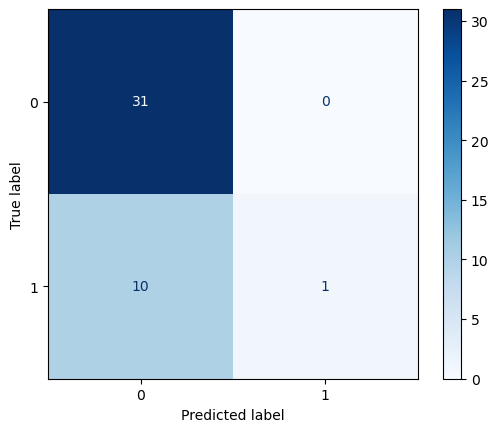

In [10]:
y_pred = bestf1_logiR.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

### 3.2 SVM with rbf kernel

In [11]:
score_measure = "f1"
kfolds = 5

param_grid = { 
            'max_iter': np.arange(2000,2500),
            'C': np.arange(1,20),
            'gamma': np.arange(0, 5, 0.1)
}

rbfSVM = SVC(kernel="rbf")
rand_search_rbfSVM = RandomizedSearchCV(estimator = rbfSVM, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1,  
                           return_train_score=True)

_ = rand_search_rbfSVM.fit(X_train, y_train.values.ravel())

print(f"The best {score_measure} score is {rand_search_rbfSVM.best_score_}")
print(f"... with parameters: {rand_search_rbfSVM.best_params_}")

bestf1 = rand_search_rbfSVM.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
The best f1 score is 0.3704761904761905
... with parameters: {'max_iter': 2305, 'gamma': 0.2, 'C': 17}


In [12]:
#chosen parameters after random search
param_grid = {
            'max_iter': np.arange(2300,2310),
            'C': np.arange(16,19),
            'gamma':np.arange(0.1, 0.6, 0.1)
}

grid_search_rbfSVM = GridSearchCV(estimator = rbfSVM, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  
                           return_train_score=True)

_ = grid_search_rbfSVM.fit(X_train, y_train.values.ravel())

print(f"The best {score_measure} score is {grid_search_rbfSVM.best_score_}")
print(f"... with parameters: {grid_search_rbfSVM.best_params_}")

bestf1_rbfSVM = grid_search_rbfSVM.best_estimator_

Fitting 5 folds for each of 150 candidates, totalling 750 fits
The best f1 score is 0.38
... with parameters: {'C': 18, 'gamma': 0.2, 'max_iter': 2300}


In [13]:
performance = performance_metrics(y_test, bestf1_rbfSVM.predict(X_test), performance, "rbf SVM")
performance

,model,Accuracy,Precision,Recall,F1
0,logistic l2,0.761905,1.000,0.090909,0.166667
0,rbf SVM,0.785714,0.625,0.454545,0.526316


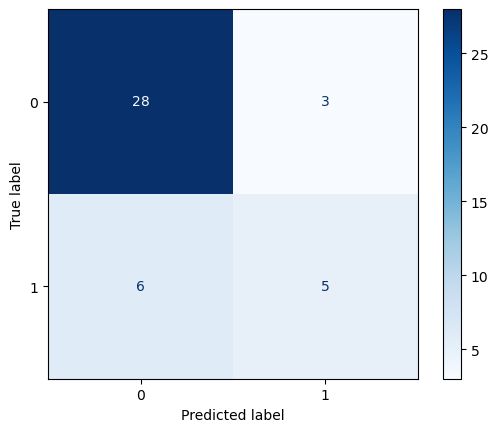

In [14]:
y_pred = bestf1_rbfSVM.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

### 3.3 Decision tree

In [15]:
score_measure = "f1"
kfolds = 5

param_grid = {
    'min_samples_split': np.arange(2,100),  
    'min_samples_leaf': np.arange(1,100),
    'min_impurity_decrease': np.arange(0.0001, 0.01, 0.0005),
    'max_leaf_nodes': np.arange(5, 200), 
    'max_depth': np.arange(1,50), 
    'criterion': ['entropy', 'gini'],
}

dtree = DecisionTreeClassifier()
rand_search_dtree = RandomizedSearchCV(estimator = dtree, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = rand_search_dtree.fit(X_train, y_train.values.ravel())

print(f"The best {score_measure} score is {rand_search_dtree.best_score_}")
print(f"... with parameters: {rand_search_dtree.best_params_}")

bestf1 = rand_search_dtree.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
The best f1 score is 0.3833333333333333
... with parameters: {'min_samples_split': 4, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0021, 'max_leaf_nodes': 132, 'max_depth': 21, 'criterion': 'entropy'}


In [16]:

param_grid = {
    'min_samples_split': np.arange(3,6),  
    'min_samples_leaf': np.arange(3,6),
    'min_impurity_decrease': np.arange(0.0020, 0.0030, 0.0001),
    'max_leaf_nodes': np.arange(131,133), 
    'max_depth': np.arange(20,22), 
    'criterion': ['entropy', 'gini'],
}

dtree = DecisionTreeClassifier()
grid_search_dtree = GridSearchCV(estimator = dtree, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search_dtree.fit(X_train, y_train.values.ravel())

print(f"The best {score_measure} score is {grid_search_dtree.best_score_}")
print(f"... with parameters: {grid_search_dtree.best_params_}")

bestf1_dtree = grid_search_dtree.best_estimator_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
The best f1 score is 0.4269841269841271
... with parameters: {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 132, 'min_impurity_decrease': 0.002499999999999999, 'min_samples_leaf': 3, 'min_samples_split': 5}


In [17]:
performance = performance_metrics(y_test, bestf1_dtree.predict(X_test), performance, "decision tree")
performance

,model,Accuracy,Precision,Recall,F1
0,logistic l2,0.761905,1.000,0.090909,0.166667
0,rbf SVM,0.785714,0.625,0.454545,0.526316
0,decision tree,0.809524,0.800,0.363636,0.500000


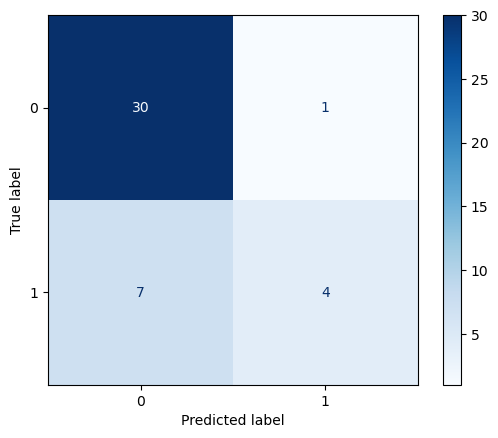

In [18]:
y_pred = bestf1_dtree.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

### 3.4 Neural Network (MLP)

In [19]:
score_measure = "f1"
kfolds = 5

param_grid = {
    'hidden_layer_sizes': [ (50,), (70,),(50,30), (40,20), (60,40, 20), (70,50,40)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0, .2, .5, .7, 1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1, 0.2, 0.5],
    'max_iter': [5000]
}

ann = MLPClassifier()
grid_search_nn = RandomizedSearchCV(estimator = ann, param_distributions=param_grid, cv=kfolds, n_iter=55,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search_nn.fit(X_train, y_train.values.ravel())

bestNN = grid_search_nn.best_estimator_

print(f"The best {score_measure} score is {grid_search_nn.best_score_}")
print(f"... with parameters: {grid_search_nn.best_params_}")


Fitting 5 folds for each of 55 candidates, totalling 275 fits
The best f1 score is 0.47111111111111115
... with parameters: {'solver': 'sgd', 'max_iter': 5000, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': (60, 40, 20), 'alpha': 0.2, 'activation': 'tanh'}


In [20]:
%%time

score_measure = "f1"
kfolds = 5

param_grid = {
    'hidden_layer_sizes': [ (50,), (70,),(40,20), (60,40, 20)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd'],
    'alpha': [.1, 0.5, 0.2, 1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'learning_rate_init':[0.005, 0.01, 0.1, 0.15],
    'max_iter': [5000]
}

ann = MLPClassifier()
grid_search_nn = GridSearchCV(estimator = ann, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search_nn.fit(X_train, y_train.values.ravel())

bestNN = grid_search_nn.best_estimator_

print(f"The best {score_measure} score is {grid_search_nn.best_score_}")
print(f"... with parameters: {grid_search_nn.best_params_}")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
The best f1 score is 0.5142857142857143
... with parameters: {'activation': 'tanh', 'alpha': 0.2, 'hidden_layer_sizes': (60, 40, 20), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'max_iter': 5000, 'solver': 'sgd'}
CPU times: user 3.05 s, sys: 292 ms, total: 3.34 s
Wall time: 3min 12s


In [21]:
%%time
y_pred = bestNN.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86        31
           1       0.60      0.55      0.57        11

    accuracy                           0.79        42
   macro avg       0.72      0.71      0.71        42
weighted avg       0.78      0.79      0.78        42

CPU times: user 13.4 ms, sys: 2.36 ms, total: 15.8 ms
Wall time: 14.6 ms


In [22]:
performance = performance_metrics(y_test, bestNN.predict(X_test), performance, "NN MLP")
performance

,model,Accuracy,Precision,Recall,F1
0,logistic l2,0.761905,1.000,0.090909,0.166667
0,rbf SVM,0.785714,0.625,0.454545,0.526316
0,decision tree,0.809524,0.800,0.363636,0.500000
0,NN MLP,0.785714,0.600,0.545455,0.571429


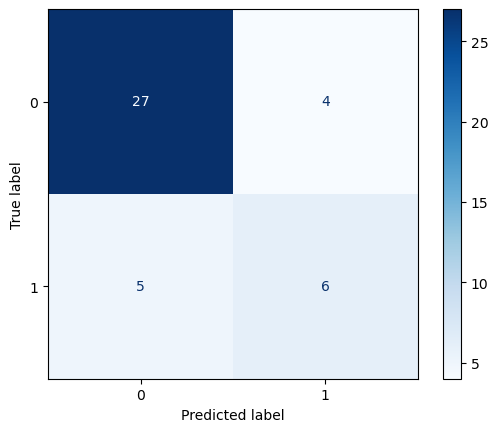

In [37]:
# display the confusion matrix
y_pred = bestNN.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

### 3.5 Neural Network (Keras Sequential model)

In [6]:
#### https://stackoverflow.com/questions/37657260/how-to-implement-custom-metric-in-keras
#### https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
# from keras import backend as K

# def f1(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [24]:

num_features = len(X_train.columns)
def build_clf(hidden_layer_sizes, dropout):
    ann = tf.keras.models.Sequential()
    ann.add(keras.layers.Input(shape=num_features)),
    for hidden_layer_size in hidden_layer_sizes:
        ann.add(keras.layers.Dense(hidden_layer_size, kernel_initializer= tf.keras.initializers.GlorotNormal(), 
                                     bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation='tanh'))
        ann.add(keras.layers.Dropout(dropout))
    ann.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # ann.compile(loss = 'binary_crossentropy', metrics = ['accuracy', f1])
    return ann


In [25]:
keras_clf = KerasClassifier(
    model=build_clf,
    hidden_layer_sizes=num_features,
    dropout = 0.1,
    optimizer=keras.optimizers.Adam,
    optimizer__learning_rate=0.0001
)

In [26]:
params = {
    'model__hidden_layer_sizes': [ (50,), (70,),(50,30), (40,20), (60,40, 20), (70,50,40)],
    'model__dropout': [0, 0.1],
    'batch_size':[2, 4, 7], 
    'epochs':[5, 10, 30], 
    'optimizer':["adam",'sgd'],
    'optimizer__learning_rate': [0.0005, 0.001, 0.005],
    'loss':['binary_crossentropy']

}
keras_clf.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'hidden_layer_sizes', 'dropout', 'optimizer__learning_rate', 'class_weight'])

Random Search

In [27]:
# from tensorflow.keras.callbacks import EarlyStopping
kfolds = 5
rnd_search_cv = RandomizedSearchCV(estimator=keras_clf, param_distributions=params, scoring="f1", n_iter=50, cv=kfolds)

# import sys
# sys.setrecursionlimit(10000) # note: the default is 3000 (python 3.9)

# earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
# callback = [earlystop]

# _ = rnd_search_cv.fit(X_train, y_train, callbacks=callback, verbose=1)
_ = rnd_search_cv.fit(X_train, y_train,  verbose=1)


Epoch 1/30
11/11 [==============================] - 1s 2ms/step - loss: 0.7310
Epoch 2/30
11/11 [==============================] - 0s 3ms/step - loss: 0.6914
Epoch 3/30
11/11 [==============================] - 0s 3ms/step - loss: 0.6565
Epoch 4/30
11/11 [==============================] - 0s 3ms/step - loss: 0.6241
Epoch 5/30
11/11 [==============================] - 0s 2ms/step - loss: 0.5981
Epoch 6/30
11/11 [==============================] - 0s 3ms/step - loss: 0.5763
Epoch 7/30
11/11 [==============================] - 0s 2ms/step - loss: 0.5555
Epoch 8/30
11/11 [==============================] - 0s 3ms/step - loss: 0.5378
Epoch 9/30
11/11 [==============================] - 0s 3ms/step - loss: 0.5202
Epoch 10/30
11/11 [==============================] - 0s 3ms/step - loss: 0.5053
Epoch 11/30
11/11 [==============================] - 0s 3ms/step - loss: 0.4930
Epoch 12/30
11/11 [==============================] - 0s 2ms/step - loss: 0.4788
Epoch 13/30
11/11 [==============================

In [28]:
best_net = rnd_search_cv.best_estimator_
print(f"The best {score_measure} score is {rnd_search_cv.best_score_}")
print(f"... with parameters: {rnd_search_cv.best_params_}")

The best f1 score is 0.4347619047619048
... with parameters: {'optimizer__learning_rate': 0.005, 'optimizer': 'adam', 'model__hidden_layer_sizes': (60, 40, 20), 'model__dropout': 0.1, 'loss': 'binary_crossentropy', 'epochs': 30, 'batch_size': 4}


In [29]:
y_pred = best_net.predict(X_test)
print(classification_report(y_test, y_pred))

11/11 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        31
           1       0.62      0.45      0.53        11

    accuracy                           0.79        42
   macro avg       0.72      0.68      0.69        42
weighted avg       0.77      0.79      0.77        42



grid search

In [32]:
params_2 = {
    'optimizer__learning_rate': [0.001, 0.005],
    'model__hidden_layer_sizes': [ (70,),(50,30), (60,40, 20)],
    'model__dropout': [0.1],
    'batch_size':[4, 7], 
    'epochs':[30, 50], 
    'optimizer':["adam"],
    'loss':['binary_crossentropy']
}

grid_search_nn_keras = GridSearchCV(estimator=keras_clf, param_grid=params_2, scoring="f1", cv=kfolds,
                                    n_jobs=-1, return_train_score=True)

# sys.setrecursionlimit(10000) # note: the default is 3000 (python 3.9)

# earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
# callback = [earlystop]

# _ = grid_search_nn_keras.fit(X_train, y_train, callbacks=callback, verbose=0)
_ = grid_search_nn_keras.fit(X_train, y_train,  verbose=1)

bestNN_Keras = grid_search_nn_keras.best_estimator_

print(f"The best {score_measure} score is {grid_search_nn_keras.best_score_}")
print(f"... with parameters: {grid_search_nn_keras.best_params_}")

Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
19/19 [==============================] - 1s 2ms/step - loss: 0.6482
Epoch 2/30
19/19 [==============================] - 0s 2ms/step - loss: 0.5944
Epoch 3/30
19/19 [==============================] - 0s 2ms/step - loss: 0.5334
Epoch 4/30
20/20 [==============================] - 1s 2ms/step - loss: 0.7049
Epoch 2/30
19/19 [==============================] - 0s 2ms/step - loss: 0.5029
Epoch 6/30
20/20 [==============================] - 1s 3ms/step - loss: 0.6715
Epoch 2/30
20/20 [==============================] - 0s 3ms/step - loss: 0.6442
Epoch 3/30
20/20 [==============================] - 0s 3ms/step - loss: 0.6080
Epoch 3/30
20/20 [==============================] - 0s 3ms/step - loss: 0.5664
Epoch 4/30
20/20 [==============================] - 0s 2ms/step - loss: 0.5492
Epoch 4/30
19/19 [==============================] - 0s 3ms/step - loss: 0.4608
Epoch 8/30
20/20 [==============================] - 0s 2ms/step - loss: 0.5393
Epoch 5/30
20/20 [=

In [33]:
y_pred = bestNN_Keras.predict(X_test)
print(classification_report(y_test, y_pred))

11/11 [==============================] - 0s 838us/step
              precision    recall  f1-score   support

           0       0.84      0.87      0.86        31
           1       0.60      0.55      0.57        11

    accuracy                           0.79        42
   macro avg       0.72      0.71      0.71        42
weighted avg       0.78      0.79      0.78        42



In [34]:
performance = performance_metrics(y_test, bestNN_Keras.predict(X_test), performance, "NN Keras")
performance

11/11 [==============================] - 0s 1ms/step


,model,Accuracy,Precision,Recall,F1
0,logistic l2,0.761905,1.000,0.090909,0.166667
0,rbf SVM,0.785714,0.625,0.454545,0.526316
0,decision tree,0.809524,0.800,0.363636,0.500000
0,NN MLP,0.785714,0.600,0.545455,0.571429
0,NN Keras,0.785714,0.600,0.545455,0.571429


11/11 [==============================] - 0s 2ms/step


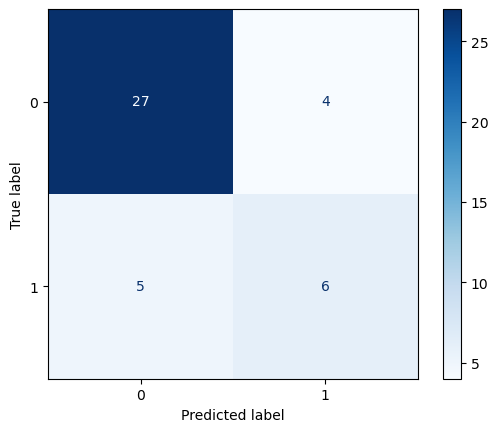

In [38]:
# display the confusion matrix
y_pred = bestNN_Keras.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

## 4. Summary

In [39]:
performance.sort_values(by=['F1'])

,model,Accuracy,Precision,Recall,F1
0,logistic l2,0.761905,1.000,0.090909,0.166667
0,decision tree,0.809524,0.800,0.363636,0.500000
0,rbf SVM,0.785714,0.625,0.454545,0.526316
0,NN MLP,0.785714,0.600,0.545455,0.571429
0,NN Keras,0.785714,0.600,0.545455,0.571429


The NN (MLP and Keras, which had the same metrics) outperformed the other methods for the reduced feature data set. 
It does a bit better than guessing (scores of 0.5) but is still insufficient. 

From the confusion matrices, it is easy to note that the problem relies on predicting the disease's positive recurrence. This is due because of the data imbalance, the number of observations for the people that progress is still low. But even, when I balanced the data by oversampling, the performance of the models did not change or got worse. 

All of these observations confirm that the data set is still not so good in order to train a classifier that correctly predicts the recurrence of invasive breast cancer. This problem could be solved by increasing the number of observations or this might suggest that the features are not so good for the prediction of the prognosis of the disease.